1. импортируем необходимые для работы библиотеки


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn
import random


2. генерация случайных точек вокруг трех центров

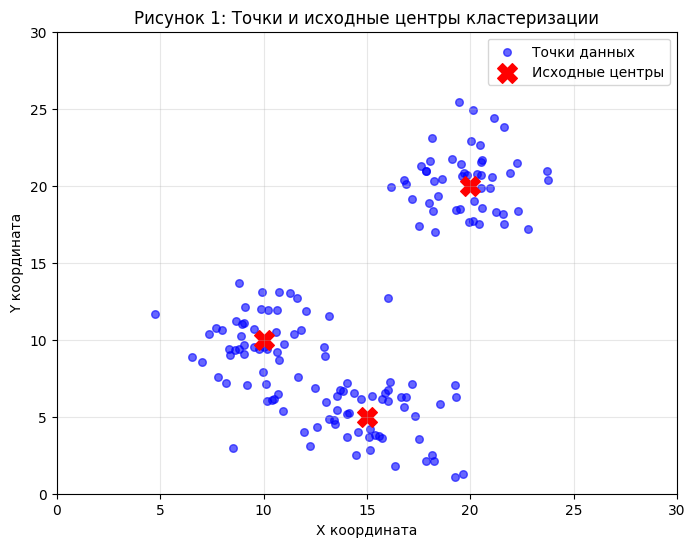

Сгенерировано 150 точек вокруг центров:
  Центр 1: [10 10]
  Центр 2: [20 20]
  Центр 3: [15  5]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

def generate_sample_data():
    "Генерация случайных точек вокруг трех центров (как на рисунке 1)"
    centers = [
        [10, 10],
        [20, 20],
        [15, 5]
    ]

    np.random.seed(42)
    data = []
    true_labels = []

    for i, center in enumerate(centers):
        n_points = 50
        cluster_data = np.random.normal(loc=center, scale=2.0, size=(n_points, 2))
        data.extend(cluster_data)
        true_labels.extend([i] * n_points)

    return np.array(data), np.array(true_labels), np.array(centers)

X, true_labels, true_centers = generate_sample_data()

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6, s=30, c='blue', label='Точки данных')
plt.scatter(true_centers[:, 0], true_centers[:, 1],
           c='red', s=200, marker='X', label='Исходные центры')
plt.title('Рисунок 1: Точки и исходные центры кластеризации')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

print(f"Сгенерировано {len(X)} точек вокруг центров:")
for i, center in enumerate(true_centers):
    print(f"  Центр {i+1}: {center}")

3. определение потенциалов на первом шаге алгоритма

Параметр alpha: 0.1016


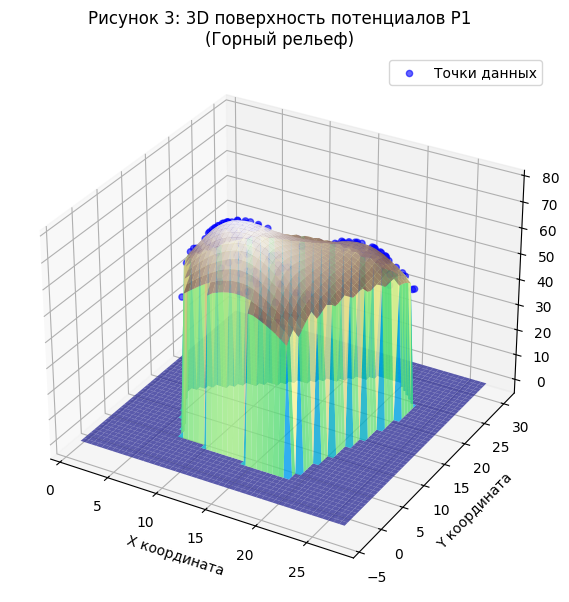

Максимальный потенциал P1: 76.1697
Минимальный потенциал P1: 42.1361


In [24]:
def calculate_initial_potentials(X, alpha):
    """Вычисление начальных потенциалов точек"""
    n = X.shape[0]
    P = np.zeros(n)

    for i in range(n):
        for j in range(n):
            if i != j:
                distance = np.linalg.norm(X[i] - X[j])
                P[i] += np.exp(-alpha * distance)

    return P

distances = []
for i in range(len(X)):
    for j in range(i+1, len(X)):
        distances.append(np.linalg.norm(X[i] - X[j]))
mean_distance = np.mean(distances)
alpha = 1.0 / mean_distance

print(f"Параметр alpha: {alpha:.4f}")

# Вычисление начальных потенциалов P1
P1 = calculate_initial_potentials(X, alpha)

# Визуализация потенциалов P1 (Рисунок 3)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Создание сетки для 3D поверхности
def create_surface_grid(X, potentials, grid_size=50):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    x_padding = (x_max - x_min) * 0.2
    y_padding = (y_max - y_min) * 0.2

    x_grid = np.linspace(x_min - x_padding, x_max + x_padding, grid_size)
    y_grid = np.linspace(y_min - y_padding, y_max + y_padding, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

    Z_grid = griddata(X, potentials, (X_grid, Y_grid), method='cubic', fill_value=0)
    return X_grid, Y_grid, Z_grid

X_grid, Y_grid, Z_grid = create_surface_grid(X, P1)
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='terrain',
                      alpha=0.8, edgecolor='none', antialiased=True)

# Точки данных
ax.scatter(X[:, 0], X[:, 1], P1, c='blue', s=20, alpha=0.6, label='Точки данных')

ax.set_title('Рисунок 3: 3D поверхность потенциалов P1\n(Горный рельеф)')
ax.set_xlabel('X координата')
ax.set_ylabel('Y координата')
ax.set_zlabel('Потенциал')
ax.legend()

plt.show()

print(f"Максимальный потенциал P1: {np.max(P1):.4f}")
print(f"Минимальный потенциал P1: {np.min(P1):.4f}")

4. упорядочивание потенциалов точек

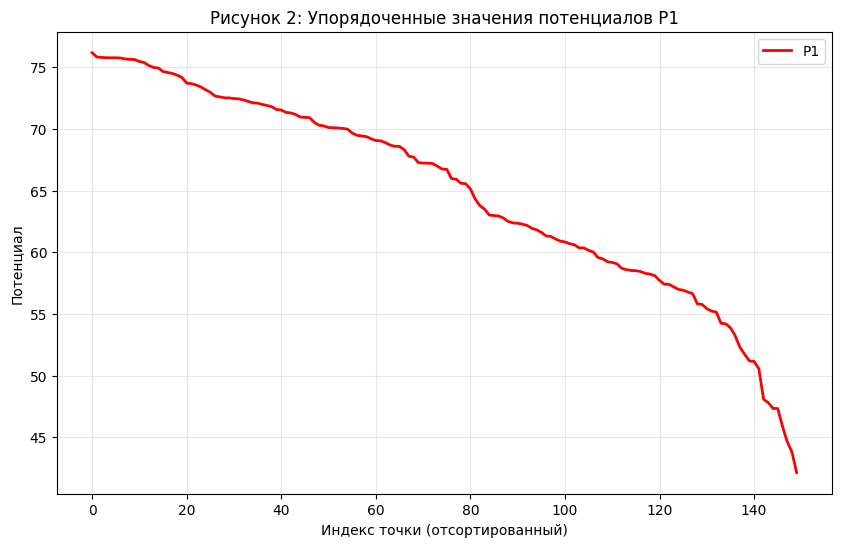

Статистика потенциалов P1:
  Максимальный: 76.1697
  Минимальный: 42.1361
  Средний: 64.8259
  Медиана: 66.7326

Топ-5 точек с наибольшим потенциалом:
  1. Точка 41: координаты [12.95578809  8.96345956], потенциал = 76.1697
  2. Точка 119: координаты [13.67642707  6.70486667], потенциал = 75.8230
  3. Точка 0: координаты [10.99342831  9.7234714 ], потенциал = 75.7855
  4. Точка 10: координаты [12.93129754  9.5484474 ], потенциал = 75.7642
  5. Точка 112: координаты [14.05613627  7.17790119], потенциал = 75.7641


In [25]:
# Упорядочивание потенциалов P1 по убыванию (для наглядности)
sorted_P1 = np.sort(P1)[::-1]

# Визуализация (Рисунок 2)
plt.figure(figsize=(10, 6))
plt.plot(sorted_P1, 'r-', linewidth=2, label='P1')
plt.title('Рисунок 2: Упорядоченные значения потенциалов P1')
plt.xlabel('Индекс точки (отсортированный)')
plt.ylabel('Потенциал')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Анализ распределения потенциалов
print("Статистика потенциалов P1:")
print(f"  Максимальный: {np.max(P1):.4f}")
print(f"  Минимальный: {np.min(P1):.4f}")
print(f"  Средний: {np.mean(P1):.4f}")
print(f"  Медиана: {np.median(P1):.4f}")

# Топ-5 точек с наибольшим потенциалом
top_indices = np.argsort(P1)[-5:][::-1]
print("\nТоп-5 точек с наибольшим потенциалом:")
for i, idx in enumerate(top_indices):
    print(f"  {i+1}. Точка {idx}: координаты {X[idx]}, потенциал = {P1[idx]:.4f}")

5. определение центра первого кластера

Центр первого кластера:
  Индекс точки: 41
  Координаты: [12.95578809  8.96345956]
  Потенциал: 76.1697

Сравнение с исходными центрами:
  Ближайший исходный центр: [10 10] (центр 1)
  Расстояние до ближайшего центра: 3.1323


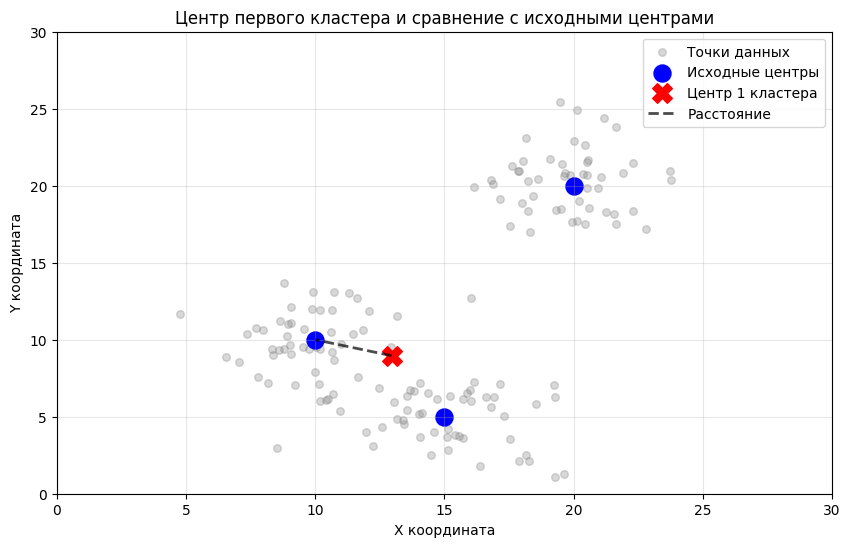

In [26]:
# Находим центр первого кластера
first_center_idx = np.argmax(P1)
first_center = X[first_center_idx]
first_center_potential = P1[first_center_idx]

print(f"Центр первого кластера:")
print(f"  Индекс точки: {first_center_idx}")
print(f"  Координаты: {first_center}")
print(f"  Потенциал: {first_center_potential:.4f}")

# Сравнение с ближайшим исходным центром
distances_to_true_centers = [np.linalg.norm(first_center - center) for center in true_centers]
closest_true_center_idx = np.argmin(distances_to_true_centers)
closest_true_center = true_centers[closest_true_center_idx]
distance_to_closest = distances_to_true_centers[closest_true_center_idx]

print(f"\nСравнение с исходными центрами:")
print(f"  Ближайший исходный центр: {closest_true_center} (центр {closest_true_center_idx + 1})")
print(f"  Расстояние до ближайшего центра: {distance_to_closest:.4f}")

# Визуализация центра первого кластера
plt.figure(figsize=(10, 6))

# Все точки
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, s=30, c='gray', label='Точки данных')

# Исходные центры
plt.scatter(true_centers[:, 0], true_centers[:, 1],
           c='blue', s=150, marker='o', label='Исходные центры')

# Найденный центр первого кластера
plt.scatter(first_center[0], first_center[1],
           c='red', s=200, marker='X', label='Центр 1 кластера')

# Соединяем с ближайшим исходным центром
plt.plot([first_center[0], closest_true_center[0]],
         [first_center[1], closest_true_center[1]],
         'k--', linewidth=2, alpha=0.7, label='Расстояние')

plt.title('Центр первого кластера и сравнение с исходными центрами')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

6. реализация остальных шагов алгоритма

Запуск полного алгоритма горной кластеризации...
Найден кластер 1: [12.95578809  8.96345956], потенциал = 76.1697
Найден кластер 2: [19.61527807 20.60309468], потенциал = 40.0747


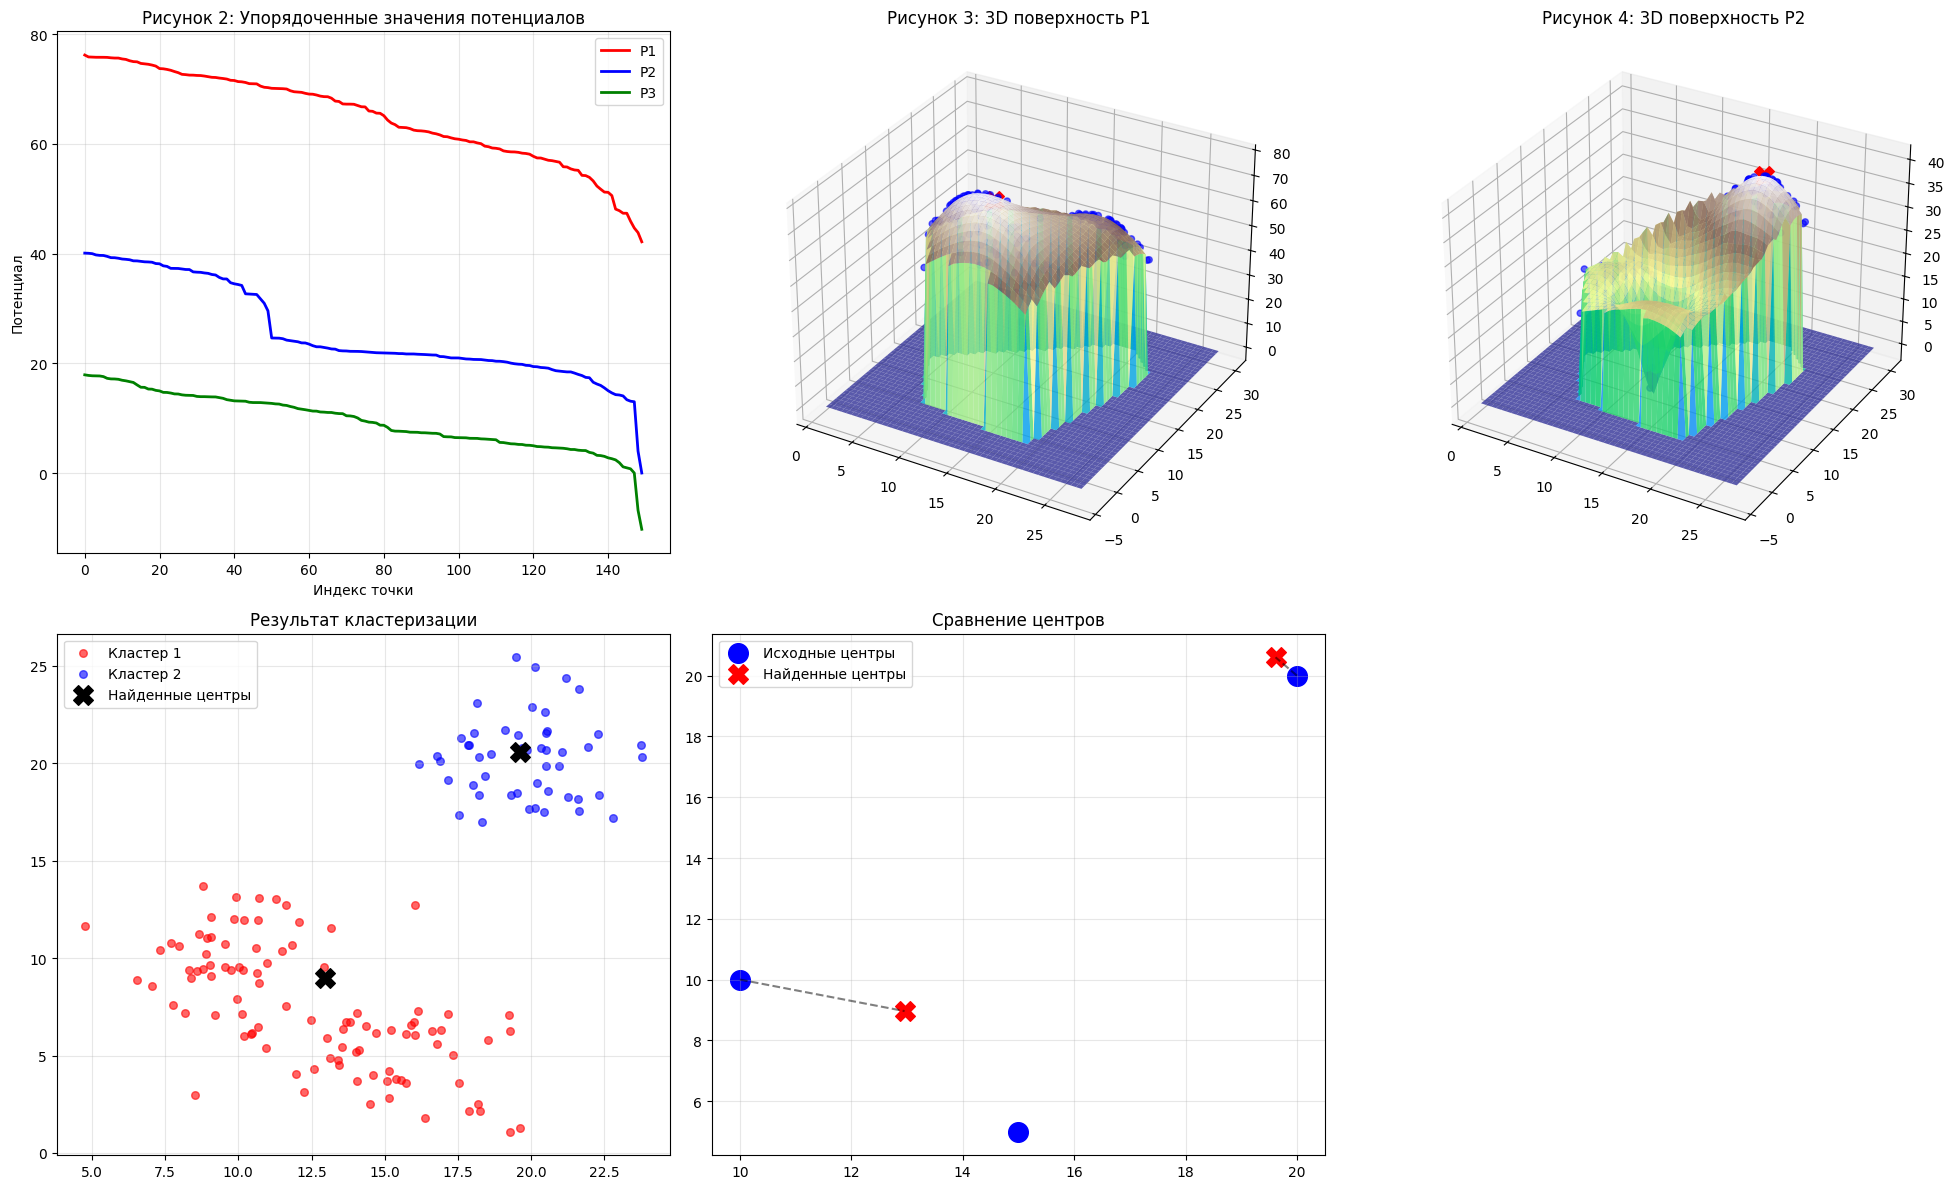


ИТОГОВЫЙ ОТЧЕТ:
Найдены центры кластеров:
  Кластер 1: [12.95578809  8.96345956]
    Исходный центр: [10 10]
    Расстояние: 3.1323
  Кластер 2: [19.61527807 20.60309468]
    Исходный центр: [20 20]
    Расстояние: 0.7154


In [27]:
class MountainClustering:
    def __init__(self, alpha, beta=None, threshold_ratio=0.5):
        self.alpha = alpha
        self.beta = beta if beta else alpha
        self.threshold_ratio = threshold_ratio
        self.centers = []
        self.potentials_history = []

    def calculate_initial_potentials(self, X):
        n = X.shape[0]
        P = np.zeros(n)
        for i in range(n):
            for j in range(n):
                if i != j:
                    distance = np.linalg.norm(X[i] - X[j])
                    P[i] += np.exp(-self.alpha * distance)
        return P

    def update_potentials(self, X, P, center):
        new_P = P.copy()
        center_idx = np.argmin(np.linalg.norm(X - center, axis=1))
        center_potential = P[center_idx]

        for i in range(len(P)):
            distance = np.linalg.norm(X[i] - center)
            new_P[i] -= center_potential * np.exp(-self.beta * distance)

        return new_P

    def fit(self, X):
        # Начальные потенциалы
        P = self.calculate_initial_potentials(X)
        self.potentials_history.append(P.copy())

        threshold = self.threshold_ratio * np.max(P)

        iteration = 0
        while np.max(P) > threshold and iteration < 3:
            center_idx = np.argmax(P)
            center = X[center_idx]
            self.centers.append(center)

            print(f"Найден кластер {iteration + 1}: {center}, потенциал = {P[center_idx]:.4f}")

            P = self.update_potentials(X, P, center)
            self.potentials_history.append(P.copy())

            iteration += 1

    def predict(self, X):
        distances = cdist(X, np.array(self.centers))
        return np.argmin(distances, axis=1)

# Запуск полного алгоритма
print("Запуск полного алгоритма горной кластеризации...")
clusterer = MountainClustering(alpha=alpha)
clusterer.fit(X)

# Визуализация всех результатов
fig = plt.figure(figsize=(20, 12))

# 1. Упорядоченные потенциалы (Рисунок 2)
ax1 = fig.add_subplot(231)
colors = ['red', 'blue', 'green']
for i, P in enumerate(clusterer.potentials_history[:3]):
    sorted_P = np.sort(P)[::-1]
    ax1.plot(sorted_P, label=f'P{i+1}', color=colors[i], linewidth=2)
ax1.set_title('Рисунок 2: Упорядоченные значения потенциалов')
ax1.set_xlabel('Индекс точки')
ax1.set_ylabel('Потенциал')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 3D поверхность P1 (Рисунок 3)
ax2 = fig.add_subplot(232, projection='3d')
P1 = clusterer.potentials_history[0]
X_grid, Y_grid, Z_grid = create_surface_grid(X, P1)
ax2.plot_surface(X_grid, Y_grid, Z_grid, cmap='terrain', alpha=0.8)
ax2.scatter(X[:, 0], X[:, 1], P1, c='blue', s=20, alpha=0.6)
if clusterer.centers:
    ax2.scatter(clusterer.centers[0][0], clusterer.centers[0][1],
               np.max(P1), c='red', s=200, marker='X')
ax2.set_title('Рисунок 3: 3D поверхность P1')

# 3. 3D поверхность P2 (Рисунок 4)
ax3 = fig.add_subplot(233, projection='3d')
if len(clusterer.potentials_history) > 1:
    P2 = clusterer.potentials_history[1]
    X_grid, Y_grid, Z_grid = create_surface_grid(X, P2)
    ax3.plot_surface(X_grid, Y_grid, Z_grid, cmap='terrain', alpha=0.8)
    ax3.scatter(X[:, 0], X[:, 1], P2, c='blue', s=20, alpha=0.6)
    if len(clusterer.centers) > 1:
        ax3.scatter(clusterer.centers[1][0], clusterer.centers[1][1],
                   np.max(P2), c='red', s=200, marker='X')
    ax3.set_title('Рисунок 4: 3D поверхность P2')

# 4. Результаты кластеризации
ax4 = fig.add_subplot(234)
if clusterer.centers:
    labels = clusterer.predict(X)
    colors = ['red', 'blue', 'green']
    for i in range(len(clusterer.centers)):
        cluster_points = X[labels == i]
        ax4.scatter(cluster_points[:, 0], cluster_points[:, 1],
                  alpha=0.6, s=30, color=colors[i], label=f'Кластер {i+1}')

    found_centers = np.array(clusterer.centers)
    ax4.scatter(found_centers[:, 0], found_centers[:, 1],
               c='black', s=200, marker='X', label='Найденные центры')
    ax4.set_title('Результат кластеризации')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Сравнение центров
ax5 = fig.add_subplot(235)
ax5.scatter(true_centers[:, 0], true_centers[:, 1],
           c='blue', s=200, marker='o', label='Исходные центры')
if clusterer.centers:
    found_centers = np.array(clusterer.centers)
    ax5.scatter(found_centers[:, 0], found_centers[:, 1],
               c='red', s=200, marker='X', label='Найденные центры')

    for i, (true_center, found_center) in enumerate(zip(true_centers, found_centers)):
        ax5.plot([true_center[0], found_center[0]], [true_center[1], found_center[1]],
                'k--', alpha=0.5)
ax5.set_title('Сравнение центров')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Итоговый отчет
print("\nИТОГОВЫЙ ОТЧЕТ:")
print("Найдены центры кластеров:")
for i, center in enumerate(clusterer.centers):
    true_center = true_centers[i] if i < len(true_centers) else None
    print(f"  Кластер {i+1}: {center}")
    if true_center is not None:
        distance = np.linalg.norm(center - true_center)
        print(f"    Исходный центр: {true_center}")
        print(f"    Расстояние: {distance:.4f}")